# Physics-Informed Integral Network for Laplace Equation
(Please reference to our paper **Physics-Informed Boundary Integral Networks (PIBI-Nets): a Data-Driven Approach for Solving Partial Differential Equations**.)

---
## Problem setup
 
### Laplace equation 
$$ \Delta u(x) := \frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} = 0 $$
 
$$x:=(x_1, x_2)\, \in \Omega \subseteq \mathbb{R}^2$$
 
For sake of simplicity, we choose $\Omega$ to be a circle.
 
### Single and double layer potential
For a point $x\in\Omega$ inside the domain we have 
$$u(x) = \left( \int_{\partial \Omega} G(x,y)\cdot \frac{\partial g}{\partial n}(y) dS_y \right) - \left(\int_{\partial \Omega} \frac{\partial G}{\partial n}(x,y)\cdot g(y) dS_y \right).$$
But for a boundary point $x\in\Gamma:=\partial\Omega$ we have get a jump
$$
u(x) = \left( \int_{\partial \Omega} G(x,y)\cdot \frac{\partial g}{\partial n}(y) dS_y \right) - \left(\int_{\partial \Omega} \frac{\partial G}{\partial n}(x,y)\cdot g(y) dS_y \right) +
\frac{1}{2}g(x).
$$
 
 
 
### Uniformal sampled datapoints based on FD solution given by Dirichlet boundary conditions
Let ${\large\{}u_i(x){\large\}}_{i=0}^{i=N}$ be the measurements constructed by a finite difference solution of the Laplace equation based on Dirichlet boundary conditions

## Load packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # colormaps
from matplotlib.font_manager import FontProperties
import pandas as pd
import os

In [2]:
matplotlib.rcParams['text.usetex'] = True
# font properties for plot titles
font_axis = FontProperties()
font_axis.set_family('serif')
font_axis.set_name('Times New Roman')
font_axis.set_size(115)  # Set the font size to match LaTeX, e.g., 12pt
# font properties for 3d plot titles
font_axis_3d = FontProperties()
font_axis_3d.set_family('serif')
font_axis_3d.set_name('Times New Roman')
font_axis_3d.set_size(90)  # Set the font size to match LaTeX, e.g., 12pt

## Dataset setup

In [3]:
# read data from CSV file into a pandas DataFrame and save as Torch tensor
def read_data(csv_file):
    """
    read csv file and store data in x_data, u_data
    
    Args:
    - csv_file
    
    Returns:
    - x_data: tensor of shape (N,2) containing N positions x=(x1,x2)
    - u_data: tensor of shape (N,1) containing u values to corresponding x
    
    """

    # read data from CSV file into a pandas DataFrame and save as Torch tensor
    data_pd = pd.read_csv(csv_file)
    # convert pandas DataFrame to PyTorch tensor
    data_tensor = torch.tensor(data_pd.values, dtype=torch.float32)  # x1, x2, u
    x_data = data_tensor[:, 0:2]  # x1, x2, (N,2)
    u_data = data_tensor[:, 2].view(-1, 1)  # u, (N,1)
    return x_data, u_data


x_data, u_data = read_data('dataset_laplace.csv')
x_data.shape

torch.Size([90, 2])

In [4]:
x_new = []
u_new = []
x_remove = []
x_data = np.array(x_data)
u_data = np.array(u_data)
limit = 0.8

for k in range(u_data.shape[0]):
    if (-limit < x_data[k,0]) & (x_data[k,0]<limit) & (-limit < x_data[k,1]) & (x_data[k,1]<limit):
        x_remove.append(x_data[k,:])
    else:
        x_new.append(x_data[k,:])
        u_new.append(u_data[k,:])

        
x_data = torch.tensor(np.array(x_new))
u_data = torch.tensor(np.array(u_new))
x_data.shape

torch.Size([30, 2])

## Physics initialisation

In [5]:
# outer normal directional derivative on boundary of Omega (as a circle)
def outer_normal(x, radius, middle):
    """
    computes outer normal vector normals that is orthogonal to surface of Omega
    
    Args:
    - x: tensor of shape (N,2) containing N positions (x1, x2) on boundary of Omega
    
    Returns:
    - normals: tensor of shape (N,2) containing the outer normal vector on boundary of Omega at each position in x
    
    """

    N = x.shape[0]  # number of points
    xc = x - middle  # cetered
    normals = xc / radius

    return normals


# Physics initialisation for 2D Laplace equation Δ𝑢(𝑥):= ∂^2(𝑢)/∂(𝑥_1)^2 + ∂^2(𝑢)/∂(𝑥_2)^2 = 0
# fundamental solution of Laplace equation in 2D
def fundamental_solution(x, y):
    """
    computes the fundamental solution of the Laplace equation in 2D at N positions in  
    two points x and y in R^2, given by
    Phi_0(x, y) = -1/(2π) * log(||x - y||)
    
    Args:
    - x: torch.tensor of position x on Domain Omega, shape (N,2)
    - y: torch.tensor of position y on Domain Omega, shape (N,2) 
    
    Returns:
    - Phi_0: torch.tensor of shape (N,1), value of Laplace fundamental solution over x and y
    
    """

    distance = torch.norm(x - y, p=2, dim=1).view(-1, 1) + 1e-8
    # check if distance is >0, otherwise raise an error because ln(0) = -infinity
    # if (distance == 0).any():
    #     raise ValueError("Points must be distinct")  # produce error

    Phi_0 = -1 / (2 * np.pi) * torch.log(distance)
    return Phi_0


# gradient of fundamental solution with respect to y
# grad Phi_0(x,y) = 1/(2π) * (x - y)/||x - y||²
def gradient_fundamental(x, y):
    """
    computes the gradient *with respect to x* of the Laplace fundamental solution in 2D at N positions x and y, 
    given by ∇y Phi_0(x,y) = - 1/(2π) * (x - y)/||x - y||²
    
    Args:
    - x: torch.tensor of position x on Domain Omega, shape (N,2)
    - y: torch.tensor of position y on Domain Omega, shape (N,2) 
    
    Returns:
    - grad_Phi_0: torch.tensor of shape (N,2), gradient of Laplace fundamental solution over x and y
    
    """
    distance = torch.norm(x - y + 1e-8, p=2, dim=1).view(-1, 1)

    # check if distance is >0, otherwise raise an error
    # if (distance == 0).any():
    #     raise ValueError("Points must be distinct")  # produce error
    grad_Phi_0 = (1 / (2 * np.pi)) * ((x - y) / distance ** 2)
    return grad_Phi_0

## Collocation and integration points

In [6]:
def collocation_integration_points(n, radius, middle):
    # add random shift
    angle = (2 * np.pi * torch.rand(1)).item()

    # define angles
    n = n + 1
    theta = np.linspace(0, 2 * np.pi, n) + angle
    theta = theta[1::]  # to remove one double angle at 0 and 2*pi
    # split theta into two sets
    theta_coll = theta[::2]  # select every second point
    theta_int = theta[1::2]  # select every other points

    # define collocation points
    x1_coll = middle[:, 0] + radius * np.cos(theta_coll).reshape(int(n / 2), 1)
    x2_coll = middle[:, 1] + radius * np.sin(theta_coll).reshape(int(n / 2), 1)
    x_collocation = np.concatenate((x1_coll, x2_coll), axis=1)
    x_collocation = torch.tensor(x_collocation, dtype=torch.float32).requires_grad_(True)

    # define integration points
    x1_int = middle[:, 0] + radius * np.cos(theta_int).reshape(int(n / 2), 1)
    x2_int = middle[:, 1] + radius * np.sin(theta_int).reshape(int(n / 2), 1)
    x_integration = np.concatenate((x1_int, x2_int), axis=1)
    x_integration = torch.tensor(x_integration, dtype=torch.float32).requires_grad_(True)

    return x_collocation, x_integration  # each of shape (n/2, 2)

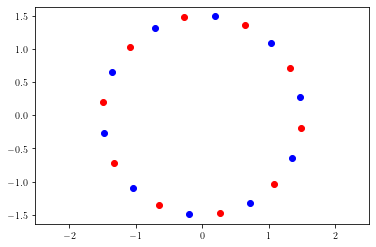

In [7]:
n = 20
radius = 1.5
middle = torch.tensor((0, 0)).view(1, 2)
x_collocation, x_integration = collocation_integration_points(n, radius, middle)
x_coll_np = x_collocation.detach().numpy()
x_int_np = x_integration.detach().numpy()

# plot collocation and integration points
plt.scatter(x_coll_np[:, 0], x_coll_np[:, 1], color='red', label='Collocation Points')
plt.scatter(x_int_np[:, 0], x_int_np[:, 1], color='blue', label='Integration Points')
plt.axis('equal')
plt.show()

## FD mesh

In [8]:
# read data from CSV file into a pandas DataFrame and save as Torch tensor
x_num = pd.read_csv('X_mesh.csv')
# convert pandas DataFrame to PyTorch tensor
x_num = torch.tensor(x_num.values, dtype=torch.float32)  # x1, x2

# read data from CSV file into a pandas DataFrame and save as Torch tensor
u_num = pd.read_csv('u_num.csv')
# convert pandas DataFrame to PyTorch tensor
u_num = torch.tensor(u_num.values, dtype=torch.float32)  # u

N = u_num.shape
N

torch.Size([10201, 1])

## Network setup

In [9]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    n_integration_points = 1_000

    def __init__(self, N_input, N_output, N_hidden, N_layers):
        """
        class implementation of a fully-connected neural network with PyTorch given by Args
        
        Args:
        - N_input: integer, number of input dimension, here N_input = 2 given by x=(x1, x2)
        - N_output: integer, number of output dimession, here N_output = 1 given by u(x)
        - N_hidden: integer, depth of one hidden layer
        - N_layers: integer, number of hidden layers in the network
        
        Methods:
        - forward: forward pass of neural network
        
        """
        super().__init__()
        activation = nn.ELU

        # input / start layer
        self.fc_start = nn.Sequential(*[
            nn.Linear(N_input, N_hidden),
            activation()
        ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
            nn.Sequential(*[
                nn.Linear(N_hidden, N_hidden),
                activation()
            ])
            for _ in range(N_layers - 1)  # -1 since first layer already defined before for-loop
        ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output)

        self.x_coll, self.x_int = collocation_integration_points(self.n_integration_points, radius, middle)
        self.vmapped_potential = torch.vmap(self.calc_potentials, randomness='same')
        self.vmapped_potential_xcol = torch.vmap(self.calc_potentials_xcoll, randomness='same')

    def resample(self):
        self.x_coll, self.x_int = collocation_integration_points(self.n_integration_points, radius, middle)
        self.vmapped_potential = torch.vmap(self.calc_potentials, randomness='same')
        self.vmapped_potential_xcol = torch.vmap(self.calc_potentials_xcoll, randomness='same')

    def predict_u_inside(self, x):
        double_layer, single_layer = self.vmapped_potential(x)
        u_int_data = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)
        return u_int_data

    def predict_u_boundary(self, x):
        double_layer, single_layer = self.vmapped_potential_xcol(x)
        u_int_boundary = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)
        return u_int_boundary

    def forward(self, x):
        """
        forward pass through network building blocks given in this class above
        
        Args:
        - x: tensor of shape (N, 2) containing N positions (x1, x2)

        Returns:
        - u: tensor of shape (N,1) containing the network solution u at position x
        
        """
        # forward network
        x = self.fc_start(x)  # input layer
        x = self.fc_hidden(x)  # hidden layer(s)
        u = self.fc_end(x)  # output layer

        return u

    def calc_potentials(self, x):
        """
        Inner domain points
        :param x:
        :return:
        """
        # single_layer
        # define collocation and integration points
        y = self.x_int
        # normal vectors
        normal_y = outer_normal(y, radius, middle)
        # boundary density
        g_y = self(y)
        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(g_y)
        dg_dy = torch.autograd.grad(g_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        dg_dn = torch.sum(dg_dy * normal_y, dim=1).view(-1, 1)
        single_layer = torch.mean(G * dg_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = torch.mean(dG_dn * g_y)
        return double_layer.squeeze(), single_layer.squeeze()

    def calc_potentials_xcoll(self, x):
        """
        for boundary
        :param x:
        :return:
        """
        y = self.x_int
        g_y = self(y)

        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(g_y)
        dg_dy = torch.autograd.grad(g_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        normal_y = outer_normal(y, radius, middle)
        dg_dn = torch.sum(dg_dy * normal_y, dim=1).view(-1, 1)
        single_layer = torch.mean(G * dg_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = torch.mean(dG_dn * g_y) - 0.5 * pibi(x)
        return double_layer.squeeze(), single_layer.squeeze()

In [10]:
def initialise_pibi(lr):
    # define number of neurons in each layer type
    N_input = 2
    N_output = 1
    N_hidden = 512
    N_layers = 3  # number of hidden layers

    # define a neural network to train
    pibi = FCNN(N_input, N_output, N_hidden, N_layers)

    # optimizer
    optimiser = torch.optim.Adam(pibi.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.5, eps=1e-12, verbose=True)

    # loss function
    mse_loss = torch.nn.MSELoss()  # Mean squared error

    return pibi, optimiser, scheduler, mse_loss

## Train PIBI and visualise trained solution

In [11]:
def train_pibi(iterations, lambda_physics_data, lambda_physics_coll, n, pibi, optimiser, scheduler, mse_loss):
    # n: number of collocation and integration points
    # store loss values
    loss_values = []
    # x_coll, x_int = collocation_integration_points(n, radius, middle)
    # vmapped_potential = torch.vmap(pibi.calc_potentials, randomness='same')
    # vmapped_potential_xcol = torch.vmap(pibi.calc_potentials_xcoll, randomness='same')

    for epoch in range(iterations):
        # Clear gradients before forward and backward pass for each batch to avoid accumulation of gradients
        optimiser.zero_grad()
        pibi.resample()
        x_coll = pibi.x_coll

        u_int_data = pibi.predict_u_inside(x_data)
        loss_int_data = mse_loss(u_int_data, u_data)

        u_int_coll = pibi.predict_u_boundary(x_coll)
        loss_int_coll = mse_loss(u_int_coll, torch.zeros_like(u_int_coll))

        # backpropagate weighted joint loss, take optimiser step
        loss = lambda_physics_data * loss_int_data + lambda_physics_coll * loss_int_coll
        loss_values.append(loss.item())  # store loss value for convergence plot
        loss.backward()
        optimiser.step()
        scheduler.step(loss)

        # plot result as training progresses on test set
        if epoch % 2 == 0:
            print('epoch:', epoch, ', data:', loss_int_data.data, ', coll:', loss_int_coll.data)

            if epoch == iterations - 1:
                # save model
                torch.save(pibi.state_dict(), "pibi_model.pt")

                # solve integral for plot points
                _, x_int = collocation_integration_points(n, radius, middle)
                u_pibi = pibi.predict_u_inside(x_num)
                x1 = (x_num[:, 0]).reshape((101, 101))  # (test_size,test_size)
                x2 = (x_num[:, 1]).reshape((101, 101))  # (test_size,test_size)
                u_nn = u_pibi.reshape(x1.shape)  # nn output, (test_size,test_size)
                u_nn = u_nn.detach()

                # evaluation plot in 3D
                fig = plt.figure(figsize=(15, 15))
                ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
                surf = ax.plot_surface(x1, x2, u_nn, cmap=cm.jet, zorder=1, alpha=1)
                ax.scatter(x_data[:, 0], x_data[:, 1], u_data, c='black', marker='o', s=10 ** 2, alpha=1, zorder=2)
                surf.set_clim(vmin=-1, vmax=1)  # limits to colorbar
                # fig.colorbar(surf, shrink=0.45, aspect=10, pad=0.2)
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # fig.axes[1].tick_params(axis="both", labelsize=45)
                # axis ticks
                ax.tick_params(axis="both", labelsize=60, pad=20)
                major_ticks = [-1, -0.5, 0, 0.5, 1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                ax.set_zticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                ax.tick_params(axis='z', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_ylabel('$x_2$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_zlabel('$u$', fontproperties=font_axis_3d, labelpad=55)
                # plt.title(f"PIBI-Net at epoch {epoch}", size=20)
                # Save the figure as a JPEG image
                plt.savefig('pibi_3d_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()

                # evaluation plot in 2d
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_nn, cmap='jet', origin='lower',
                                extent=[torch.min(x1).item(), torch.max(x1).item(),
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=-1, vmax=1)
                ax.scatter(x_data[:, 0], x_data[:, 1], c='black', marker='o', s=10 ** 2, alpha=1, zorder=4)
                # fig.colorbar(img, ax=ax, shrink=0.55, aspect=10, pad=0.2)
                # tick sizes
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # fig.axes[1].tick_params(axis="both", labelsize=45)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1, -0.5, 0, 0.5, 1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                # plt.title(f"PIIBI-Net at epoch {epoch} (Top view)", size=20)
                # Save the figure as a JPEG image 
                plt.savefig('pibi_2d_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()

                # absolute error plot
                u_num_matrix = u_num.reshape(u_nn.shape)
                u_error = torch.abs(u_nn - u_num_matrix)
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_error, cmap='jet_r', origin='lower',
                                extent=[torch.min(x1).item(), torch.max(x1).item(),
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=0, vmax=1.1)
                ax.scatter(x_data[:, 0], x_data[:, 1], c='black', marker='o', s=10 ** 2, alpha=1, zorder=4)
                #fig.colorbar(img, ax=ax, shrink=0.55, aspect=10, pad=0.2)
                # tick sizes
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # fig.axes[1].tick_params(axis="both", labelsize=45)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1, -0.5, 0, 0.5, 1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                # plt.title('Absolute error (Top View)', size=20)
                plt.savefig('pibi_error_bc.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                u_vec = u_error.reshape(N, 1)
                print('min', torch.min(u_vec), 'max', torch.max(u_vec), 'mean', torch.mean(u_vec))

    return loss_values, pibi


epoch: 0 , data: tensor(0.0025) , coll: tensor(142.0249)
epoch: 2 , data: tensor(0.0025) , coll: tensor(142.1433)
epoch: 4 , data: tensor(0.0024) , coll: tensor(142.2217)
epoch: 6 , data: tensor(0.0024) , coll: tensor(142.3536)
epoch: 8 , data: tensor(0.0024) , coll: tensor(142.4325)
epoch: 10 , data: tensor(0.0024) , coll: tensor(142.5652)
epoch: 12 , data: tensor(0.0024) , coll: tensor(142.6485)
epoch: 14 , data: tensor(0.0024) , coll: tensor(142.7623)
epoch: 16 , data: tensor(0.0024) , coll: tensor(142.8762)
epoch: 18 , data: tensor(0.0024) , coll: tensor(142.9506)
epoch: 20 , data: tensor(0.0024) , coll: tensor(143.0910)
epoch: 22 , data: tensor(0.0024) , coll: tensor(143.1692)
epoch: 24 , data: tensor(0.0024) , coll: tensor(143.2769)
epoch: 26 , data: tensor(0.0024) , coll: tensor(143.3700)
epoch: 28 , data: tensor(0.0023) , coll: tensor(143.4728)
epoch: 30 , data: tensor(0.0023) , coll: tensor(143.5709)
epoch: 32 , data: tensor(0.0023) , coll: tensor(143.6788)
epoch: 34 , data: t

epoch: 280 , data: tensor(0.0015) , coll: tensor(156.1563)
epoch: 282 , data: tensor(0.0015) , coll: tensor(156.2180)
epoch: 284 , data: tensor(0.0015) , coll: tensor(156.3726)
epoch: 286 , data: tensor(0.0015) , coll: tensor(156.4675)
epoch: 288 , data: tensor(0.0015) , coll: tensor(156.4865)
epoch: 290 , data: tensor(0.0015) , coll: tensor(156.6257)
epoch: 292 , data: tensor(0.0015) , coll: tensor(156.7321)
epoch: 294 , data: tensor(0.0015) , coll: tensor(156.7869)
epoch: 296 , data: tensor(0.0014) , coll: tensor(156.9027)
epoch: 298 , data: tensor(0.0014) , coll: tensor(157.0202)
epoch: 300 , data: tensor(0.0014) , coll: tensor(157.0881)
epoch: 302 , data: tensor(0.0014) , coll: tensor(157.1675)
epoch: 304 , data: tensor(0.0014) , coll: tensor(157.2681)
epoch: 306 , data: tensor(0.0014) , coll: tensor(157.3391)
epoch: 308 , data: tensor(0.0014) , coll: tensor(157.4419)
epoch: 310 , data: tensor(0.0014) , coll: tensor(157.5542)
epoch: 312 , data: tensor(0.0014) , coll: tensor(157.653

epoch: 556 , data: tensor(0.0010) , coll: tensor(166.0108)
epoch: 558 , data: tensor(0.0010) , coll: tensor(166.0593)
epoch: 560 , data: tensor(0.0010) , coll: tensor(166.0791)
epoch: 562 , data: tensor(0.0010) , coll: tensor(166.1443)
epoch: 564 , data: tensor(0.0010) , coll: tensor(166.1580)
epoch: 566 , data: tensor(0.0010) , coll: tensor(166.2143)
epoch: 568 , data: tensor(0.0010) , coll: tensor(166.2349)
epoch: 570 , data: tensor(0.0010) , coll: tensor(166.2886)
epoch: 572 , data: tensor(0.0010) , coll: tensor(166.3137)
epoch: 574 , data: tensor(0.0010) , coll: tensor(166.3677)
epoch: 576 , data: tensor(0.0010) , coll: tensor(166.3958)
epoch: 578 , data: tensor(0.0010) , coll: tensor(166.4358)
epoch: 580 , data: tensor(0.0010) , coll: tensor(166.4399)
epoch: 582 , data: tensor(0.0010) , coll: tensor(166.5111)
epoch: 584 , data: tensor(0.0010) , coll: tensor(166.4958)
epoch: 586 , data: tensor(0.0010) , coll: tensor(166.5872)
epoch: 588 , data: tensor(0.0010) , coll: tensor(166.562

epoch: 834 , data: tensor(0.0008) , coll: tensor(170.6217)
epoch: 836 , data: tensor(0.0008) , coll: tensor(170.6757)
epoch: 838 , data: tensor(0.0008) , coll: tensor(170.6787)
epoch: 840 , data: tensor(0.0008) , coll: tensor(170.7257)
epoch: 842 , data: tensor(0.0008) , coll: tensor(170.7451)
epoch: 844 , data: tensor(0.0008) , coll: tensor(170.7756)
epoch: 846 , data: tensor(0.0008) , coll: tensor(170.8108)
epoch: 848 , data: tensor(0.0008) , coll: tensor(170.8421)
epoch: 850 , data: tensor(0.0008) , coll: tensor(170.8703)
epoch: 852 , data: tensor(0.0008) , coll: tensor(170.8926)
epoch: 854 , data: tensor(0.0008) , coll: tensor(170.9360)
epoch: 856 , data: tensor(0.0008) , coll: tensor(170.9503)
epoch: 858 , data: tensor(0.0008) , coll: tensor(171.0172)
epoch: 860 , data: tensor(0.0008) , coll: tensor(171.0079)
epoch: 862 , data: tensor(0.0008) , coll: tensor(171.0757)
epoch: 864 , data: tensor(0.0008) , coll: tensor(171.0762)
epoch: 866 , data: tensor(0.0008) , coll: tensor(171.121

epoch: 1110 , data: tensor(0.0006) , coll: tensor(174.4474)
epoch: 1112 , data: tensor(0.0006) , coll: tensor(174.4634)
epoch: 1114 , data: tensor(0.0006) , coll: tensor(174.4870)
epoch: 1116 , data: tensor(0.0006) , coll: tensor(174.5377)
epoch: 1118 , data: tensor(0.0006) , coll: tensor(174.5541)
epoch: 1120 , data: tensor(0.0006) , coll: tensor(174.5819)
epoch: 1122 , data: tensor(0.0006) , coll: tensor(174.6213)
epoch: 1124 , data: tensor(0.0006) , coll: tensor(174.6285)
epoch: 1126 , data: tensor(0.0006) , coll: tensor(174.6732)
epoch: 1128 , data: tensor(0.0006) , coll: tensor(174.6528)
epoch: 1130 , data: tensor(0.0006) , coll: tensor(174.7146)
epoch: 1132 , data: tensor(0.0006) , coll: tensor(174.7082)
epoch: 1134 , data: tensor(0.0006) , coll: tensor(174.7257)
epoch: 1136 , data: tensor(0.0006) , coll: tensor(174.7733)
epoch: 1138 , data: tensor(0.0006) , coll: tensor(174.7556)
epoch: 1140 , data: tensor(0.0006) , coll: tensor(174.8086)
epoch: 1142 , data: tensor(0.0006) , col

epoch: 1384 , data: tensor(0.0005) , coll: tensor(177.4182)
epoch: 1386 , data: tensor(0.0005) , coll: tensor(177.4660)
epoch: 1388 , data: tensor(0.0005) , coll: tensor(177.4607)
epoch: 1390 , data: tensor(0.0005) , coll: tensor(177.5017)
epoch: 1392 , data: tensor(0.0005) , coll: tensor(177.5015)
epoch: 1394 , data: tensor(0.0005) , coll: tensor(177.5145)
epoch: 1396 , data: tensor(0.0005) , coll: tensor(177.5459)
epoch: 1398 , data: tensor(0.0005) , coll: tensor(177.5505)
epoch: 1400 , data: tensor(0.0005) , coll: tensor(177.5616)
epoch: 1402 , data: tensor(0.0005) , coll: tensor(177.5769)
epoch: 1404 , data: tensor(0.0005) , coll: tensor(177.5932)
epoch: 1406 , data: tensor(0.0005) , coll: tensor(177.6216)
epoch: 1408 , data: tensor(0.0005) , coll: tensor(177.6245)
epoch: 1410 , data: tensor(0.0005) , coll: tensor(177.6298)
epoch: 1412 , data: tensor(0.0005) , coll: tensor(177.6812)
epoch: 1414 , data: tensor(0.0005) , coll: tensor(177.6762)
epoch: 1416 , data: tensor(0.0005) , col

epoch: 1658 , data: tensor(0.0004) , coll: tensor(179.6734)
epoch: 1660 , data: tensor(0.0004) , coll: tensor(179.6712)
epoch: 1662 , data: tensor(0.0004) , coll: tensor(179.6882)
epoch: 1664 , data: tensor(0.0004) , coll: tensor(179.7104)
epoch: 1666 , data: tensor(0.0004) , coll: tensor(179.7124)
epoch: 1668 , data: tensor(0.0004) , coll: tensor(179.7164)
epoch: 1670 , data: tensor(0.0004) , coll: tensor(179.7389)
epoch: 1672 , data: tensor(0.0004) , coll: tensor(179.7507)
epoch: 1674 , data: tensor(0.0004) , coll: tensor(179.7649)
epoch: 1676 , data: tensor(0.0004) , coll: tensor(179.7921)
epoch: 1678 , data: tensor(0.0004) , coll: tensor(179.8065)
epoch: 1680 , data: tensor(0.0004) , coll: tensor(179.8188)
epoch: 1682 , data: tensor(0.0004) , coll: tensor(179.8364)
epoch: 1684 , data: tensor(0.0004) , coll: tensor(179.8514)
epoch: 1686 , data: tensor(0.0004) , coll: tensor(179.8633)
epoch: 1688 , data: tensor(0.0004) , coll: tensor(179.8828)
epoch: 1690 , data: tensor(0.0004) , col

epoch: 1930 , data: tensor(0.0004) , coll: tensor(180.6566)
epoch: 1932 , data: tensor(0.0004) , coll: tensor(180.6600)
epoch: 1934 , data: tensor(0.0004) , coll: tensor(180.6643)
epoch: 1936 , data: tensor(0.0004) , coll: tensor(180.6675)
epoch: 1938 , data: tensor(0.0004) , coll: tensor(180.6706)
epoch: 1940 , data: tensor(0.0004) , coll: tensor(180.6770)
epoch: 1942 , data: tensor(0.0004) , coll: tensor(180.6840)
epoch: 1944 , data: tensor(0.0004) , coll: tensor(180.6932)
epoch: 1946 , data: tensor(0.0004) , coll: tensor(180.6983)
epoch: 1948 , data: tensor(0.0004) , coll: tensor(180.7019)
epoch: 1950 , data: tensor(0.0004) , coll: tensor(180.7075)
epoch: 1952 , data: tensor(0.0004) , coll: tensor(180.7145)
epoch: 1954 , data: tensor(0.0004) , coll: tensor(180.7183)
epoch: 1956 , data: tensor(0.0004) , coll: tensor(180.7346)
epoch: 1958 , data: tensor(0.0004) , coll: tensor(180.7375)
epoch: 1960 , data: tensor(0.0004) , coll: tensor(180.7469)
epoch: 1962 , data: tensor(0.0004) , col

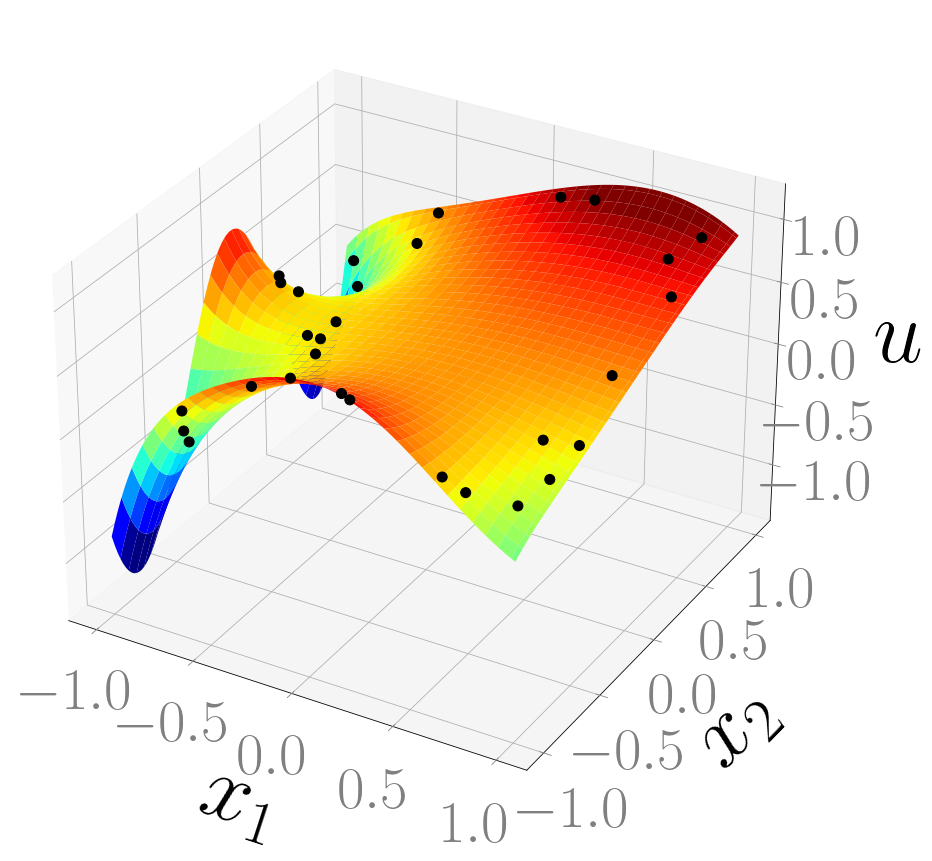

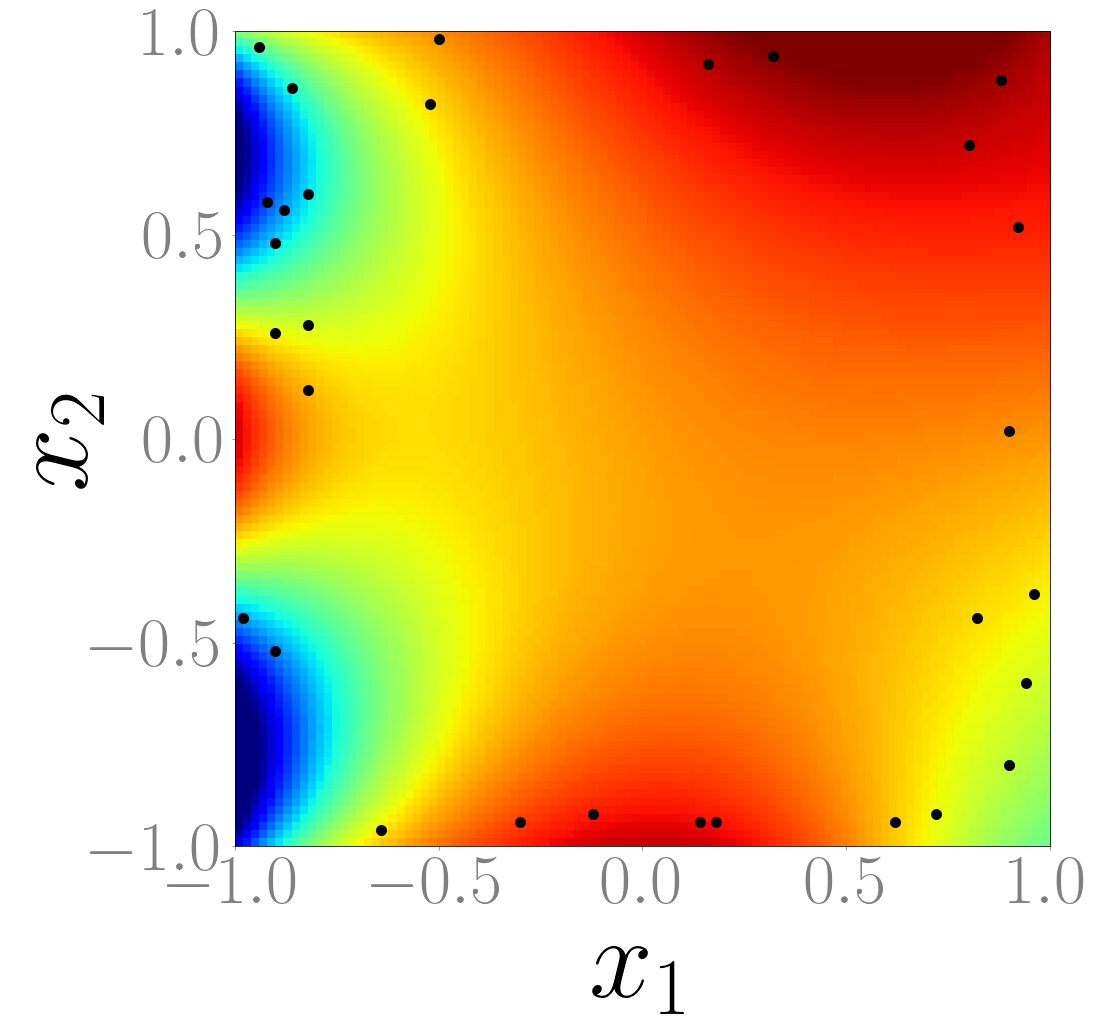

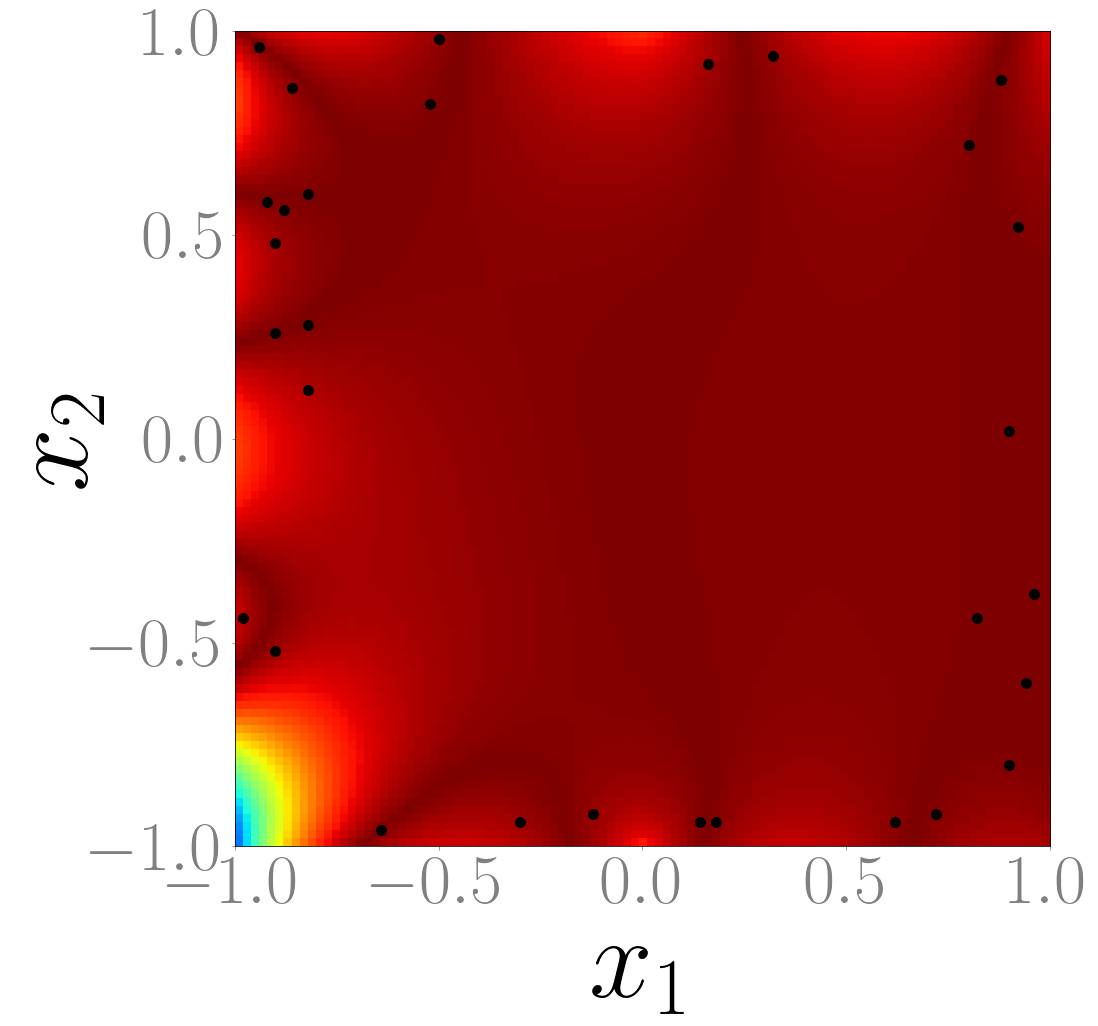

min tensor(7.7486e-07) max tensor(0.8303) mean tensor(0.0267)


In [14]:
# pibi initialisation
lr = 5e-4  # learning rate
#pibi, optimiser, scheduler, mse_loss = initialise_pibi(lr)

iterations = 2_001  # 5_000
lambda_physics_data = 1
lambda_physics_coll = 1e-6  # weighting of collocation loss
n = 1000  # number of collocation points
radius = 1.5
middle = torch.tensor((0, 0)).view(1, 2)
loss_values, pibi = train_pibi(iterations, lambda_physics_data, lambda_physics_coll, n, pibi, optimiser, scheduler,
                               mse_loss)

## Visualize convergence of loss function

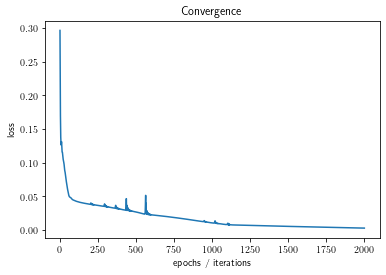

In [13]:
epochs = list(range(1, iterations + 1))
fig, ax = plt.subplots()
ax.plot(epochs, loss_values)
ax.set(xlabel='epochs / iterations',
       ylabel='loss',
       title='Convergence')
# plt.savefig('pibi_loss.jpg', dpi=1000, format='jpeg')
plt.show()